In [419]:
from pyomo.environ import *
import pandas as pd
import matplotlib.pyplot as plt

In [420]:
x10 = 20
x20 = 29
u0 = 0
data = pd.read_excel('data.xlsx', index_col=0)

In [421]:
def optimization_model(data, price):
    model = ConcreteModel()

    # DEFINE SETS
    model.T = Set(ordered=True, initialize=data.index)

    # DEFINE PARAMETERS
    model.lamb1 = Param(model.T, within=NonNegativeReals, mutable=True)
    model.lamb2 = Param(model.T, within=NonNegativeReals, mutable=True)

    # INITIALIZE PARAMETERS
    for t in model.T:
        model.lamb1[t] = data.loc[t, price]

    # DEFINE VARIABLES
    model.u = Var(model.T, within=NonNegativeReals)
    model.x1 = Var(model.T, within=NonNegativeReals)
    model.x2 = Var(model.T, within=NonNegativeReals)

    # DEFINE COST AND CONSTRAINTS
    def cost_rule(model):
        return sum(1*(model.x1[t] - 22)*(model.x1[t] - 22) + model.lamb1[t]*model.u[t] for t in model.T)
    model.cost = Objective(rule=cost_rule)

    def state_space_x1_rule(model, t):
        if model.T.ord(t) == data.index.size:
            return Constraint.Skip
        else:
            return model.x1[model.T.next(t)] == 0.9*model.x1[t] + 0.07*model.x2[t]
    model.ss_x1 = Constraint(model.T, rule=state_space_x1_rule)

    def state_space_x2_rule(model, t):
        if model.T.ord(t) == data.index.size:
            return Constraint.Skip
        else:
            return model.x2[model.T.next(t)] == 0.95*model.x2[t] + 2*model.u[t]
    model.ss_x2 = Constraint(model.T, rule=state_space_x2_rule)

    def minmax_total_cons_rule(model, t):
        return inequality(0, model.u[t], 3)
    model.minmax_total_const = Constraint(model.T, rule=minmax_total_cons_rule)

    def x10_condition(model, t):
        if model.T.ord(t) == 1:
            return model.x1[t] == x10
        else:
            return Constraint.Skip
    model.ini_cond_x0 = Constraint(model.T, rule=x10_condition)

    def x20_condition(model, t):
        if model.T.ord(t) == 1:
            return model.x2[t] == x20
        else:
            return Constraint.Skip
    model.ini_cond_x1 = Constraint(model.T, rule=x20_condition)

    def u0_condition(model, t):
        if model.T.ord(t) == 1:
            return model.u[t] == u0
        else:
            return Constraint.Skip
    model.ini_cond_u1 = Constraint(model.T, rule=u0_condition)

    return model

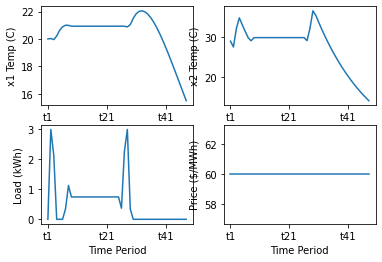

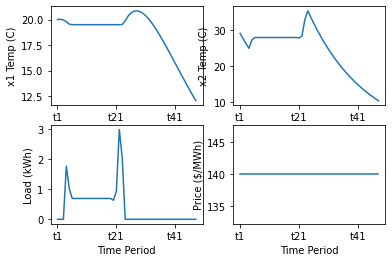

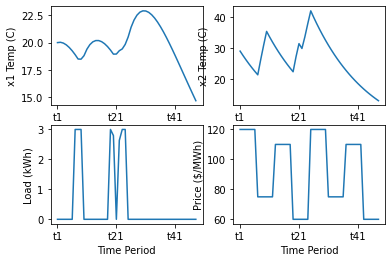

In [427]:
price = ['price1', 'price2', 'tou']

for p in price:
    model = optimization_model(data, p)
    opt = SolverFactory('gurobi')
    results = opt.solve(model)

    resData = pd.DataFrame(index=data.index, columns=['x1', 'x2', 'u', 'price'])
    for t in model.T:
        resData.loc[t, 'x1'] = value(model.x1[t])
        resData.loc[t, 'x2'] = value(model.x2[t])
        resData.loc[t, 'u'] = value(model.u[t])
        resData.loc[t, 'price'] = data.loc[t, p]
    resData

    fig, axes = plt.subplots(nrows=2, ncols=2, squeeze=False)

    resData['x1'].plot(ax=axes[0,0])
    resData['x2'].plot(ax=axes[0,1])
    axes[0,0].set_xlabel('Time Period');axes[0,0].set_ylabel('x1 Temp (C)')
    axes[0,1].set_xlabel('Time Period');axes[0,1].set_ylabel('x2 Temp (C)')

    resData['u'].plot(ax=axes[1,0])
    resData['price'].plot(ax=axes[1,1])
    axes[1,0].set_xlabel('Time Period');axes[1,0].set_ylabel('Load (kWh)')
    axes[1,1].set_xlabel('Time Period');axes[1,1].set_ylabel('Price ($/MWh)')